Conda env: `aops_mathbert`

In [1]:
import numpy as np
import pandas as pd
from time import perf_counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sns
from official.nlp import optimization  # to create AdamW optimizer

from transformers import BertTokenizer, TFBertModel

from utils.utils_for_regression import calculate_descriptive_statistics
from utils.utils_for_regression import mse_tf, rmse_tf, mae_tf, r2_score_tf
from utils.util_write_training_result import append_training_result


def compare_actual_and_predict_values(model, tokenized_list_of_texts, list_of_texts, list_of_actual, df_file_name: str):
    predicted = []
    for i in range(len(tokenized_list_of_texts[0])):
        temp = model([
            [tf.expand_dims(tokenized_list_of_texts[0][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[1][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[2][i], axis=0)]
        ])
        temp = temp.numpy().flatten()[0]
        predicted.append(temp)
    predicted = np.array(predicted)
    list_of_actual = np.array(list_of_actual)

    # for i in range(len(list_of_texts)):
    #     print(f"{str(i+1):>2s}. {list_of_texts[i]}")
    #     print(f"    Actual   Predicted")
    #     print(f"    {list_of_actual[i]:.3f}    {predicted[i]:.3f}")
    #     print()
        
    df_ = pd.DataFrame({
        'text': list_of_texts,
        'actual': list_of_actual,
        'predicted': predicted
    })
    df_ = df_.sort_values(by=['actual'], ascending=True)
    df_.reset_index(inplace=True)

    display(df_.sample(10, random_state=42).sort_values(by=['actual'], ascending=True))
    df_.to_csv(df_file_name, index=False)

def model_evaluate_and_analytics(model, tokenized_list_of_texts, list_of_actual, suptitle: str, plot_file_name: str):
    predicted = []
    for i in range(len(tokenized_list_of_texts[0])):
        temp = model([
            [tf.expand_dims(tokenized_list_of_texts[0][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[1][i], axis=0)], 
            [tf.expand_dims(tokenized_list_of_texts[2][i], axis=0)]
        ])
        temp = temp.numpy().flatten()[0]
        predicted.append(temp)
    predicted = np.array(predicted)
    list_of_actual = np.array(list_of_actual)
    
    stat_actual = calculate_descriptive_statistics(list_of_actual)
    stat_pred = calculate_descriptive_statistics(predicted)
    # print(f"           actual              predict")
    # print(f"Mean       {stat_actual['mean']}    {stat_pred['mean']}")
    # print(f"Variance   {stat_actual['variance']}    {stat_pred['variance']}")
    # print(f"STD        {stat_actual['std']}    {stat_pred['std']}")
    # print(f"min        {stat_actual['min']}    {stat_pred['min']}")
    # print(f"max        {stat_actual['max']}    {stat_pred['max']}")
    # print()

    mse_loss = mse_tf(y_true=list_of_actual, y_pred=predicted)
    rmse = rmse_tf(y_true=list_of_actual, y_pred=predicted)
    mae = mae_tf(y_true=list_of_actual, y_pred=predicted)
    r2_score = r2_score_tf(y_true=list_of_actual, y_pred=predicted)
    # print(f"loss(mse)         rmse              mae               r2")
    # print(f"{mse_loss:.12f}    {rmse:.12f}    {mae:.12f}    {r2_score:.12f}")

    fig, ax = plt.subplots(3, 2, figsize=(16, 16), constrained_layout=True)
    fig.suptitle(suptitle)
    plt.subplot(3, 2, (1,2))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.xlim((-1, 11))
    plt.title('Density Plot of Actual & Predicted Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.xlim((-1, 11))
    sns.kdeplot(list_of_actual, label='Actual', shade=True, color='blue', linewidth=2)
    plt.xlabel('Values')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.xlim((-1, 11))
    sns.kdeplot(predicted, label='Predicted', shade=True, color='red', linewidth=2)
    plt.xlabel('Values')
    plt.legend()

    # Scatter plot
    plt.subplot(3, 2, (5, 6))
    plt.scatter(list_of_actual, predicted, color='blue', marker='x', label='Data Points')
    fx_x = np.linspace(0, 10, 100)  # Generate x values for the line
    plt.plot(fx_x, fx_x, color='red', linestyle='--', label='f(x) = x')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of Predict & Actual')
    plt.grid(True)
    plt.legend()

    # Add strings to display statistics
    fs = 16
    # fig.text(0.07, 0.71, f"Actual", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.05, 0.630, f"mean     :{stat_actual['mean']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.05, 0.615, f"variance :{stat_actual['variance']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.05, 0.600, f"std      :{stat_actual['std']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.05, 0.585, f"min      :{stat_actual['min']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.05, 0.570, f"max      :{stat_actual['max']:.3f}", fontsize=fs, ha="left", fontname="Consolas")

    # fig.text(0.70, 0.71, f"Predict", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.56, 0.630, f"mean     :{stat_pred['mean']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.56, 0.615, f"variance :{stat_pred['variance']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.56, 0.600, f"std      :{stat_pred['std']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.56, 0.585, f"min      :{stat_pred['min']:.3f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.56, 0.570, f"max      :{stat_pred['max']:.3f}", fontsize=fs, ha="left", fontname="Consolas")

    fig.text(0.14, 0.035, f"MSE: {mse_loss:.7f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.34, 0.035, f"RMSE: {rmse:.7f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.54, 0.035, f"MAE: {mae:.7f}", fontsize=fs, ha="left", fontname="Consolas")
    fig.text(0.74, 0.035, f"R2 Score: {r2_score:.7f}", fontsize=fs, ha="left", fontname="Consolas")

    plt.savefig(plot_file_name)
    
    plt.show()

    result = {'mse': mse_loss, 'rmse': rmse, 'mae': mae, 'r2': r2_score}
    return {'model_eval': result}, {'actual': stat_actual}, {'pred': stat_pred}

def tokenize_text(model_name, array, max_length=512, return_tensor:bool = False):
    if model_name == "MATHBERT":
        tokenizer = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
    if model_name == "BERTBASE":
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    tokenized_list = tokenizer(array, padding='max_length', max_length=max_length, truncation=True, return_tensors='tf')
    
    if type(return_tensor) is not bool:
        raise TypeError(f"return_tensor must a boolean. Found return_tensor={type(return_tensor)}")
    if return_tensor is True:
        return tf.data.Dataset.from_tensor_slices((tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']))
    if return_tensor is False:
        return tokenized_list['input_ids'], tokenized_list['attention_mask'], tokenized_list['token_type_ids']

# epochs = [100, 150, 200, 250, 300]
# lr     = [3e-6, 3e-7]
id_note = "19"

model_name = "MATHBERT"  # MATHBERT | BERTBASE
epochs = 10
learning_rate = 3e-4
data_type = "combined_all"  # imo | combined_all

trainable_l1 = True
trainable_l2 = True
trainable_l3 = True
trainable_l4 = False
trainable_l5 = False
trainable_l6 = False
trainable_l7 = False
trainable_l8 = False
trainable_l9 = False
trainable_l10 = False
trainable_l11 = False
trainable_l12 = False


c:\Users\IBDA\.conda\envs\victor_aops_mathbert\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\IBDA\.conda\envs\victor_aops_mathbert\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

Prepare & Load Dataset

In [2]:
def load_tokenized_train_val_test_ds(model_name, path, batch_size, AUTOTUNE=tf.data.AUTOTUNE):
    df_train = pd.read_csv(f"{path}train.csv")
    df_test = pd.read_csv(f"{path}test.csv")
    df_val = pd.read_csv(f"{path}val.csv")

    train_post_canonical = list(df_train['post_canonical'].values)
    train_score = df_train['score'].values

    test_post_canonical = list(df_test['post_canonical'].values)
    test_score = df_test['score'].values

    val_post_canonical = list(df_val['post_canonical'].values)
    val_score = df_val['score'].values

    tokenized_train = tokenize_text(model_name, train_post_canonical, max_length=512, return_tensor=False)
    tokenized_test = tokenize_text(model_name, test_post_canonical, max_length=512, return_tensor=False)
    tokenized_val = tokenize_text(model_name, val_post_canonical, max_length=512, return_tensor=False)
    
    train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train, train_score))
    test_ds = tf.data.Dataset.from_tensor_slices((tokenized_test, test_score))
    val_ds = tf.data.Dataset.from_tensor_slices((tokenized_val, val_score))
    
    train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    ds = {
        'train': {'X': train_post_canonical,'y': train_score},
        'test': {'X': test_post_canonical,'y': test_score},
        'val': {'X': val_post_canonical,'y': val_score},
    }
    ds_tok = {
        'train': {'X': tokenized_train,'y': train_score},
        'test': {'X': tokenized_test,'y': test_score},
        'val': {'X': tokenized_val,'y': val_score},
    }
    
    return train_ds, val_ds, test_ds, ds, ds_tok

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

dt_mapped = {'imo': "../data/regression/imo/", 'combined_all': "../data/regression/"}
train_ds, val_ds, test_ds, datasets, datasets_tokenized = load_tokenized_train_val_test_ds(model_name, dt_mapped[data_type], batch_size=batch_size, AUTOTUNE=AUTOTUNE)


In [3]:
class MathBertRegressorModel:
    def __init__(self, max_length=512) -> None:
        self.max_length = max_length
        
        self.model = self.build_model()
        
        self.learning_rate = None
        self.train_ds = None
        self.validation_data = None
        self.epochs = None
        
        self.history = None
        self.training_time = None

    def build_model(self):
        input_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids_layer')
        attention_mask_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask_layer')
        token_type_ids_layer = tf.keras.Input(shape=(self.max_length,), dtype=tf.int32, name='token_type_ids_layer')
        inputs = [input_ids_layer, attention_mask_layer, token_type_ids_layer]
        
        if model_name == "MATHBERT":
            encoder = TFBertModel.from_pretrained("tbs17/MathBERT", from_pt=True)
        if model_name == "BERTBASE":
            encoder = TFBertModel.from_pretrained("bert-base-uncased")
        
        # encoder.trainable = False
        encoder.bert.encoder.layer[0].trainable = trainable_l1
        encoder.bert.encoder.layer[1].trainable = trainable_l2
        encoder.bert.encoder.layer[2].trainable = trainable_l3
        encoder.bert.encoder.layer[3].trainable = trainable_l4
        encoder.bert.encoder.layer[4].trainable = trainable_l5
        encoder.bert.encoder.layer[5].trainable = trainable_l6
        encoder.bert.encoder.layer[6].trainable = trainable_l7
        encoder.bert.encoder.layer[7].trainable = trainable_l8
        encoder.bert.encoder.layer[8].trainable = trainable_l9
        encoder.bert.encoder.layer[9].trainable = trainable_l10
        encoder.bert.encoder.layer[10].trainable = trainable_l11
        encoder.bert.encoder.layer[11].trainable = trainable_l12
        print()
        for i in range(len(encoder.bert.encoder.layer)):
            print(f"bert.encoder.layer[{str(i+1)}].trainable: {encoder.bert.encoder.layer[i].trainable}")
        
        encoded_text = encoder(input_ids=input_ids_layer, attention_mask=attention_mask_layer, token_type_ids=token_type_ids_layer)
        pooler_output = encoded_text['pooler_output']  # Output -> dict.keys(['last_hidden_state', 'pooler_output'])
        
        net = tf.keras.layers.Dropout(0.1, name="dropout_1")(pooler_output)
        net = tf.keras.layers.Dense(1, activation='linear', name="output_unit_linear")(net)
    
        return tf.keras.Model(inputs=inputs, outputs=net, name="regression_model")
    
    def compile_model(self, train_ds, validation_data, epochs, learning_rate, optimizer=tf.keras.optimizers.Adam(learning_rate), loss=tf.keras.losses.mean_squared_error, metrics=['mae']):
        self.train_ds = train_ds
        self.validation_data = validation_data
        self.epochs = epochs
        self.learning_rate = learning_rate
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        print()
        self.model.summary(show_trainable=True)

    def train(self):
        print("Start training..")
        start = perf_counter()
        history = self.model.fit(
            self.train_ds, 
            validation_data=self.validation_data, 
            epochs=self.epochs
        )
        end = perf_counter()
        self.training_time = end-start
        print(f"\nTotal training time: {self.training_time:.2f}s")

        self.history = history.history
        return history
    
    def evaluate_test(self, test_ds):
        self.model.evaluate(test_ds)
        
    def plot_training_history_over_time(self, suptitle: str, plot_file_name: str, figsize=(16, 6)):
        print(self.history.keys())
        print("Training history over time")
        
        train_loss = self.history['loss']
        train_mae = self.history['mae']

        val_loss = self.history['val_loss']
        val_mae = self.history['val_mae']
        epochs_list = range(1, self.epochs+1)
        
        figure, ax = plt.subplots(1, 2, figsize=figsize, layout="constrained")
        figure.suptitle(suptitle)
        
        # loss (MSE)
        plt.subplot(1, 2, 1)
        plt.plot(epochs_list, train_loss, 'r', label='Training loss (MSE)')
        plt.plot(epochs_list, val_loss, 'b', label='Validation loss (MSE)')
        plt.title('Training and validation loss (MSE)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend(loc='upper right')

        # mae
        plt.subplot(1, 2, 2)
        plt.plot(epochs_list, train_mae, 'r', label='Training MAE')
        plt.plot(epochs_list, val_mae, 'b', label='Validation MAE')
        plt.title('Training and validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend(loc='upper right')

        plt.savefig(plot_file_name)

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.mean_squared_error
metrics = ['mae']


In [4]:
mathbert_regressor_model = MathBertRegressorModel()
mathbert_regressor_model.compile_model(
    train_ds, 
    val_ds, 
    epochs=epochs, 
    learning_rate=learning_rate, 
    optimizer=optimizer, 
    loss=loss, 
    metrics=metrics
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 


bert.encoder.layer[1].trainable: True
bert.encoder.layer[2].trainable: True
bert.encoder.layer[3].trainable: True
bert.encoder.layer[4].trainable: False
bert.encoder.layer[5].trainable: False
bert.encoder.layer[6].trainable: False
bert.encoder.layer[7].trainable: False
bert.encoder.layer[8].trainable: False
bert.encoder.layer[9].trainable: False
bert.encoder.layer[10].trainable: False
bert.encoder.layer[11].trainable: False
bert.encoder.layer[12].trainable: False

Model: "regression_model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               Y          
                                                                                                             
 attention_mask_layer (InputLay  [(None, 512)]       0          

In [5]:
mathbert_regressor_model.train()


Start training..
Epoch 1/10
27/27 [==============================] - 21s 418ms/step - loss: 8.0636 - mae: 2.3052 - val_loss: 4.3162 - val_mae: 1.7382
Epoch 2/10
27/27 [==============================] - 9s 324ms/step - loss: 5.6925 - mae: 1.9578 - val_loss: 4.9006 - val_mae: 1.8403
Epoch 3/10
27/27 [==============================] - 9s 322ms/step - loss: 4.1202 - mae: 1.6448 - val_loss: 4.9917 - val_mae: 1.7620
Epoch 4/10
27/27 [==============================] - 9s 320ms/step - loss: 2.6608 - mae: 1.2557 - val_loss: 4.2809 - val_mae: 1.6839
Epoch 5/10
27/27 [==============================] - 9s 321ms/step - loss: 3.2918 - mae: 1.4582 - val_loss: 12.2743 - val_mae: 2.9268
Epoch 6/10
27/27 [==============================] - 9s 325ms/step - loss: 2.8176 - mae: 1.3553 - val_loss: 5.9521 - val_mae: 1.9554
Epoch 7/10
27/27 [==============================] - 9s 325ms/step - loss: 3.0178 - mae: 1.3948 - val_loss: 8.0311 - val_mae: 2.3677
Epoch 8/10
27/27 [==============================] - 9s 32

In [6]:
mathbert_regressor_model.evaluate_test(test_ds)


8/8 [==============================] - 1s 109ms/step - loss: 6.5078 - mae: 2.0973


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Training history over time


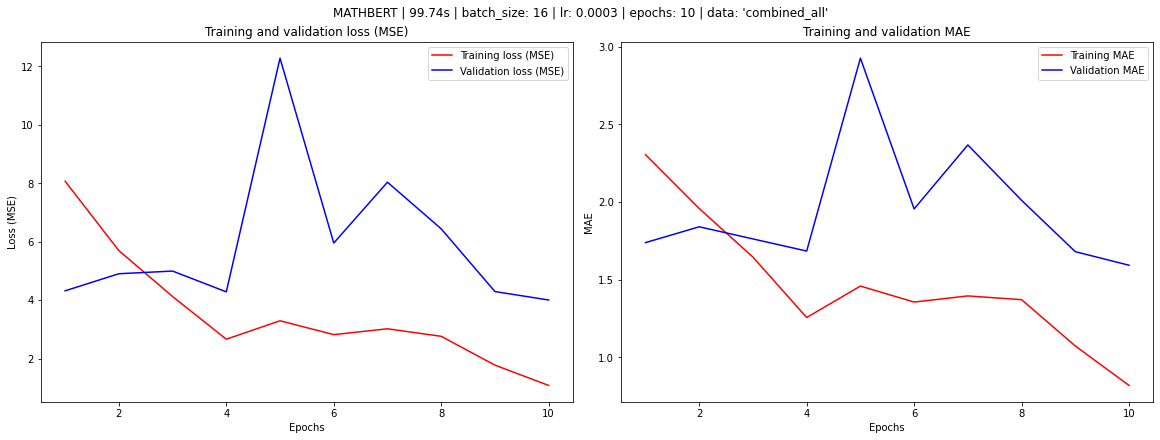

In [7]:
mathbert_regressor_model.plot_training_history_over_time(
    suptitle=f"{model_name} | {mathbert_regressor_model.training_time:.2f}s | batch_size: {batch_size} | lr: {learning_rate} | epochs: {epochs} | data: '{data_type}'",
    plot_file_name=f"saved_plots/regression/{id_note}_{model_name}_traininghistory_plot.jpg",
    )


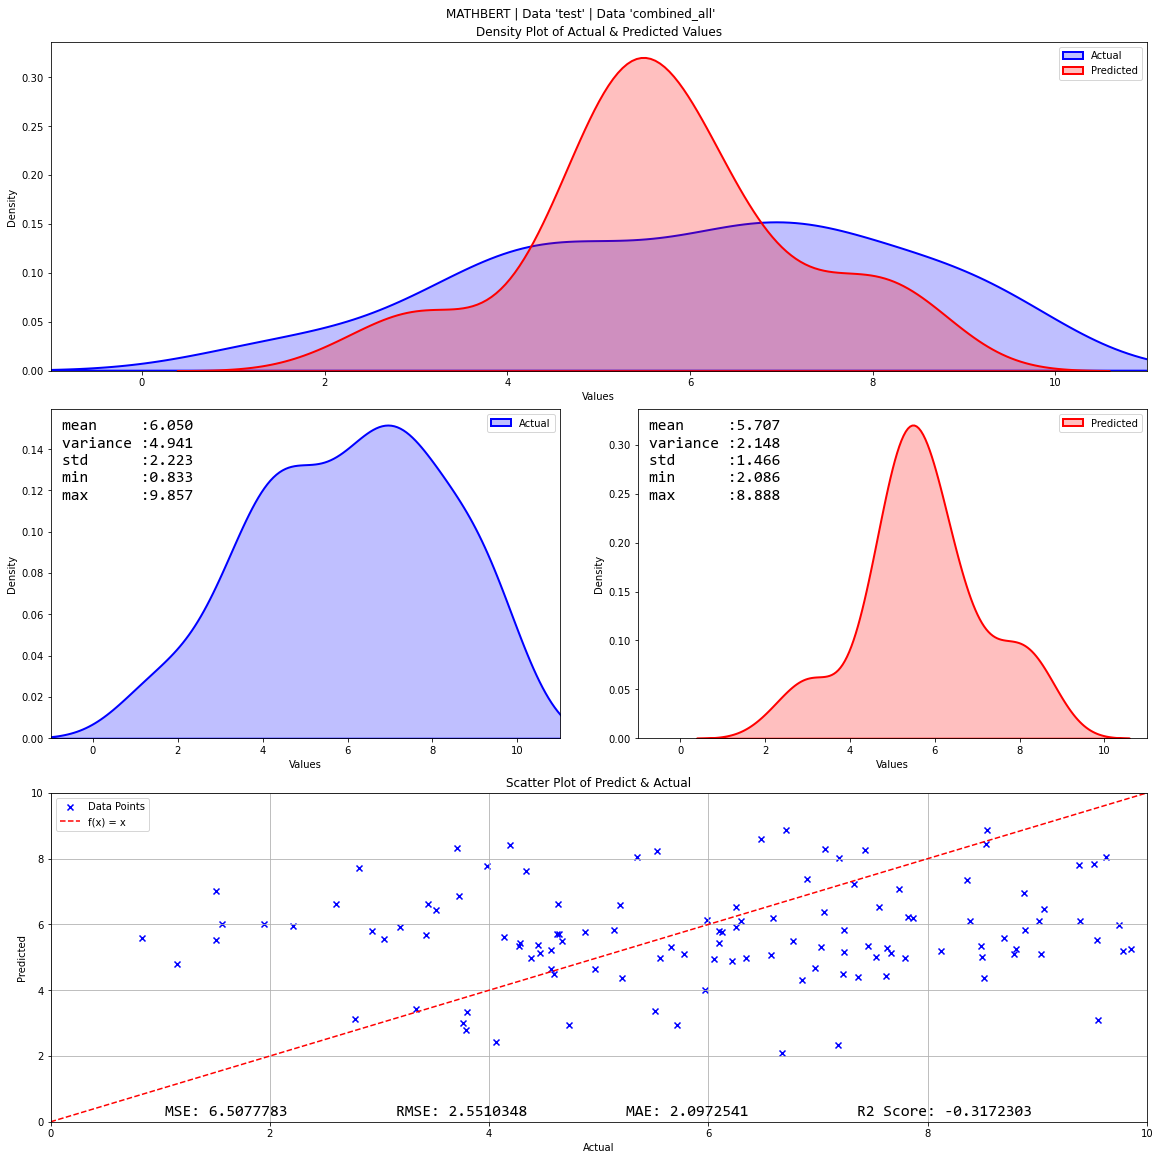

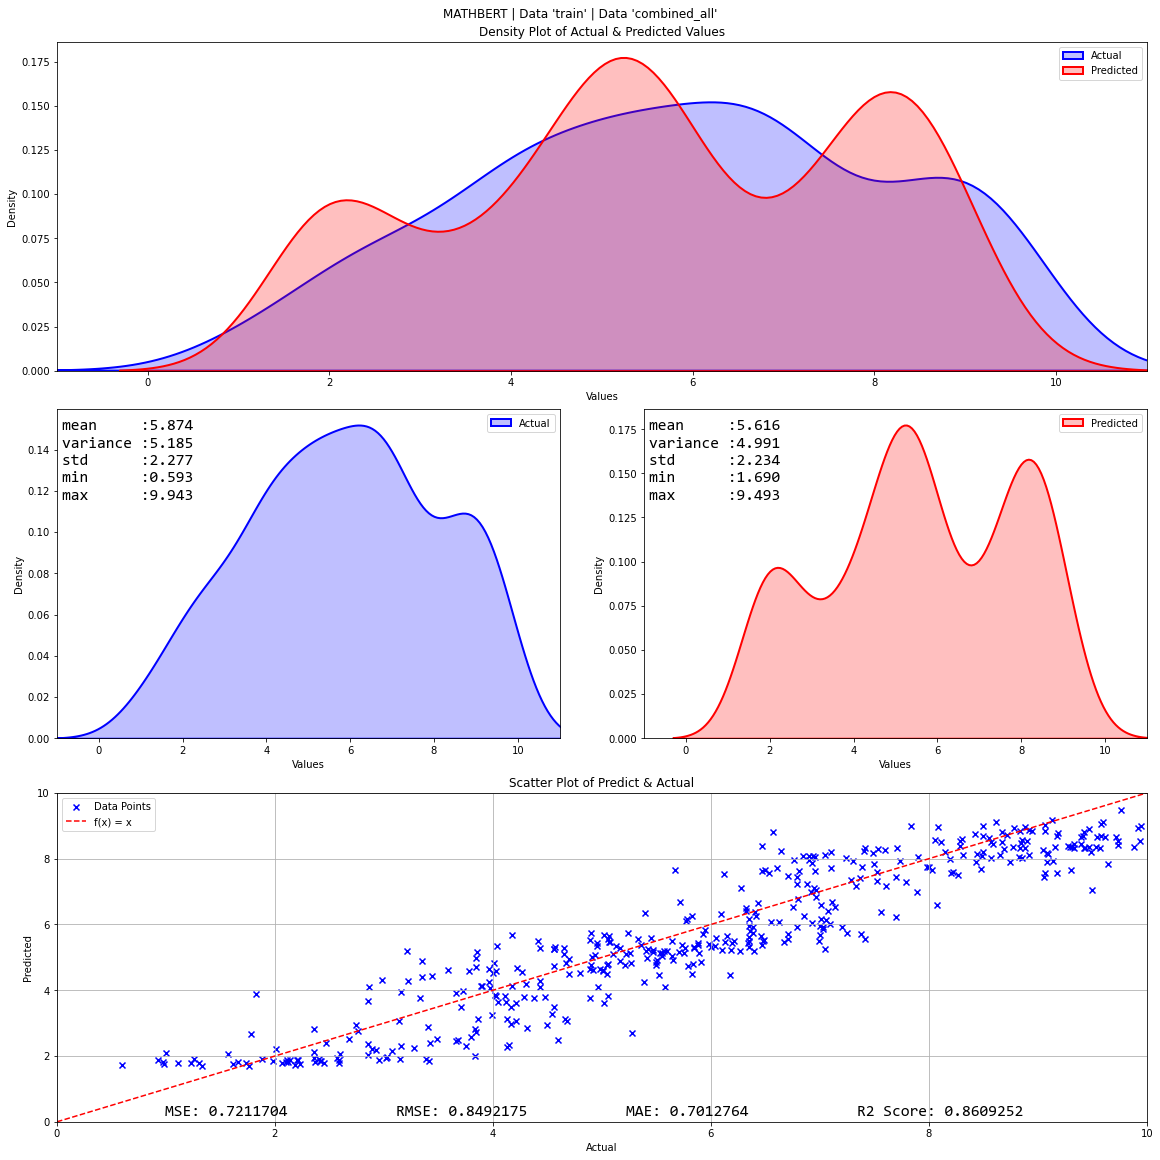

In [8]:
ds_type = 'test'
model_eval, stat_test, stat_pred = model_evaluate_and_analytics(
    mathbert_regressor_model.model, 
    datasets_tokenized[ds_type]['X'], 
    datasets_tokenized[ds_type]['y'], 
    suptitle=f"{model_name} | Data '{ds_type}' | Data '{data_type}'", 
    plot_file_name=f"saved_plots/regression/{id_note}_{model_name}_actualpredict_plot_{ds_type}.jpg",
    )
    
ds_type = 'train'
model_eval_train, stat_train, stat_trainpred = model_evaluate_and_analytics(
    mathbert_regressor_model.model, 
    datasets_tokenized[ds_type]['X'], 
    datasets_tokenized[ds_type]['y'], 
    suptitle=f"{model_name} | Data '{ds_type}' | Data '{data_type}'", 
    plot_file_name=f"saved_plots/regression/{id_note}_{model_name}_actualpredict_plot_{ds_type}.jpg",
    )


In [9]:
ds_type = "test"
compare_actual_and_predict_values(
    mathbert_regressor_model.model, 
    datasets_tokenized[ds_type]['X'], 
    datasets[ds_type]['X'], 
    datasets_tokenized[ds_type]['y'], 
    df_file_name=f"saved_plots/regression/{id_note}_{model_name}_compareabletext_{ds_type}.csv"
    )

ds_type = "train"
compare_actual_and_predict_values(
    mathbert_regressor_model.model, 
    datasets_tokenized[ds_type]['X'], 
    datasets[ds_type]['X'], 
    datasets_tokenized[ds_type]['y'], 
    df_file_name=f"saved_plots/regression/{id_note}_{model_name}_compareabletext_{ds_type}.csv"
    )


,index,text,actual,predicted
4,6,Consider decompositions of an 8 times 8 chessb...,1.559524,6.016931
10,110,A_0B_0C_0 and A_1B_1C_1 are acute-angled trian...,2.927928,5.806259
26,85,Find all positive real solutions to: begin{eqn...,4.272363,5.330821
45,55,"Let A,B be adjacent vertices of a regular n-go...",5.353741,8.038022
56,47,All faces of the tetrahedron ABCD are acute-an...,6.101449,5.802408
69,92,Let Gamma be the circumcircle of triangle ABC....,6.857143,4.311852
73,18,Let ABC be a triangle with circumcircle Omega....,7.055667,6.367024
89,49,Let n be an even positive integer. We say that...,7.736508,7.067194
90,99,"Let mathbb{N}= {1, 2, 3, dots } be the set of ...",7.792793,4.975397
116,37,Let n be a positive integer. Consider S = left...,9.782967,5.193079


,index,text,actual,predicted
30,73,For what real values of x is sqrt{x+ sqrt{2x-1...,2.361111,2.828912
72,50,"Five points A_1,A_2,A_3,A_4,A_5 lie on a plane...",3.585714,4.626343
73,322,Let mathbb{Z}^+ be the set of positive integer...,3.657143,3.903734
132,29,Let n and k be relatively prime positive integ...,4.654819,5.289419
137,416,Let ABC be a triangle with circumcentre O. The...,4.700379,4.947240
145,385,Let A be a 101-element subset of the set S= {1...,4.917162,4.623068
175,304,"Let n be an even positive integer. Let A_1, A_...",5.389126,4.247935
280,148,"Given real numbers x_1,x_2,y_1,y_2,z_1,z_2 sat...",6.953125,7.622807
410,353,"Let n ge 3 be an integer, and consider a circl...",9.577121,8.701712
419,336,Let ABCD be a quadrilateral inscribed in a cir...,9.885714,8.362660


In [10]:
data_type, batch_size, epochs, learning_rate, optimizer, training_time = data_type, batch_size, epochs, learning_rate, "tf.keras.optimizers.Adam", mathbert_regressor_model.training_time

model_name = model_name
temp = f"{id_note},regression,{model_name},{data_type},{batch_size},{epochs},{learning_rate},{optimizer},{training_time:.2f},"
temp+= f"{model_eval['model_eval']['mse']:.7f},{model_eval['model_eval']['rmse']:.7f},{model_eval['model_eval']['mae']:.7f},{model_eval['model_eval']['r2']:.7f},"
temp+= f"{trainable_l1},{trainable_l2},{trainable_l3},{trainable_l4},{trainable_l5},{trainable_l6},{trainable_l7},{trainable_l8},{trainable_l9},{trainable_l10},{trainable_l11},{trainable_l12},"
temp+= f"{stat_pred['pred']['mean']:.3f},{stat_pred['pred']['variance']:.3f},{stat_pred['pred']['std']:.3f},{stat_pred['pred']['min']:.3f},{stat_pred['pred']['max']:.3f},"
temp+= f"{stat_test['actual']['mean']:.3f},{stat_test['actual']['variance']:.3f},{stat_test['actual']['std']:.3f},{stat_test['actual']['min']:.3f},{stat_test['actual']['max']:.3f},"
temp+= f"{stat_train['actual']['mean']:.3f},{stat_train['actual']['variance']:.3f},{stat_train['actual']['std']:.3f},{stat_train['actual']['min']:.3f},{stat_train['actual']['max']:.3f}"

append_training_result("Hasil training - Regression.csv", temp)


In [11]:
# """SAVING MODEL: FIRST METHOD"""


# """NOTE: Save model"""
# mathbert_regressor_model.model.save(f"saved_models/regression/{id_note}_{model_name}", save_format='tf')


# """NOTE: Save custom_objects"""
# from utils.util import save_pkl
# from transformers import TFBertModel
# custom_objects = {'TFBertModel': TFBertModel}
# save_pkl(custom_objects, f"saved_models/regression/{id_note}_custom_objects_{model_name}.pkl")


# """NOTE: Save tokenizer"""
# from transformers import BertTokenizer
# if model_name == "MATHBERT":
#     tokenizer_ = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
#     tokenizer_.save_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")
# elif model_name == "BERTBASE":
#     tokenizer_ = BertTokenizer.from_pretrained('bert-base-uncased')
#     tokenizer_.save_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")


# """
# NOTE: How to load model and predict
# """
# import tensorflow as tf
# from utils.util import load_pkl
# from transformers import BertTokenizer

# loaded_custom_objects = load_pkl(f"saved_models/regression/{id_note}_custom_objects_{model_name}.pkl")
# loaded_model = tf.keras.models.load_model(f"saved_models/regression/{id_note}_{model_name}", custom_objects=loaded_custom_objects)
# if model_name == "MATHBERT":
#     tokenizer = BertTokenizer.from_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}", output_hidden_states=True)
# elif model_name == "BERTBASE":
#     tokenizer = BertTokenizer.from_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")

# tok = tokenizer("Given triangle ABCD", padding="max_length", max_length=512, truncation=True, return_tensors='tf')
# loaded_model.predict([
#     [tok['input_ids']],
#     [tok['attention_mask']],
#     [tok['token_type_ids']]
# ])

In [12]:
"""SAVE: SECOND METHOD"""


"""NOTE: Save model"""
mathbert_regressor_model.model.save(f"saved_models/regression/{id_note}_{model_name}", include_optimizer=False)


"""NOTE: Save tokenizer"""
from transformers import BertTokenizer
if model_name == "MATHBERT":
    tokenizer_ = BertTokenizer.from_pretrained('tbs17/MathBERT', output_hidden_states=True)
    tokenizer_.save_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")
elif model_name == "BERTBASE":
    tokenizer_ = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer_.save_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")


"""
NOTE: How to load model and predict
"""
import tensorflow as tf
from transformers import BertTokenizer

loaded_model = tf.saved_model.load(f"saved_models/regression/{id_note}_{model_name}")
if model_name == "MATHBERT":
    tokenizer = BertTokenizer.from_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}", output_hidden_states=True)
elif model_name == "BERTBASE":
    tokenizer = BertTokenizer.from_pretrained(f"saved_models/regression/{id_note}_tokenizer_{model_name}")

tok = tokenizer("Given triangle ABCD", padding="max_length", max_length=512, truncation=True, return_tensors='tf')
loaded_model([
    [tok['input_ids'][0]],
    [tok['attention_mask'][0]],
    [tok['token_type_ids'][0]]
])


INFO:tensorflow:Assets written to: saved_models/regression/19_MATHBERT\assets


INFO:tensorflow:Assets written to: saved_models/regression/19_MATHBERT\assets


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.8279922]], dtype=float32)>